<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/10_replicate_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replicate https://arxiv.org/abs/2010.11929

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 24.64 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

In [7]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image_batch.shape, image.shape, label_batch.shape, label.shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([32]),
 torch.Size([]))

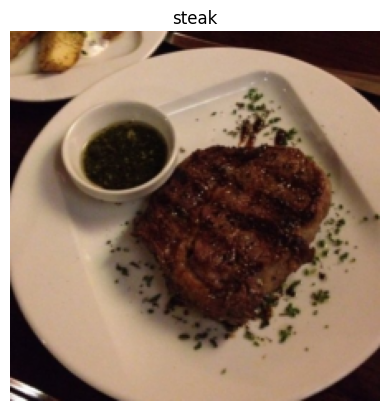

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

Input, output, layers, blocks, model  
Input>model(=block(= layer조합) 조합)>output  

  
Embedding = learnable representation

In [10]:
#input shape: (224, 224, 3) H=W=224 C=3
#N = H*W/P^(2)
#output shape: (N,P^(2)*C)
H = 224
W = 224
C = 3
P = 16

N = int(H*W/P**2)
N

196

In [11]:
input_shape = (H, W, C)
output_shape = (N, P**2*C)
input_shape, output_shape

((224, 224, 3), (196, 768))

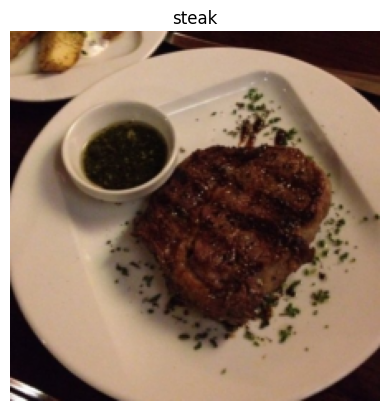

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [13]:
img_permute = image.permute(1, 2, 0) #to H,W,C
img_permute.shape

torch.Size([224, 224, 3])

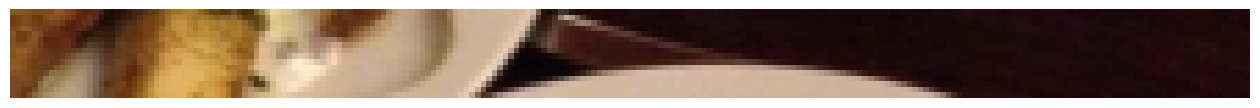

In [14]:
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permute[0:patch_size, :, :])
plt.axis(False)
plt.show()

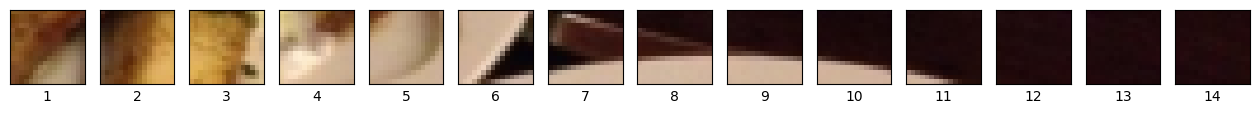

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    #print(patch)
    axs[i].imshow(img_permute[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

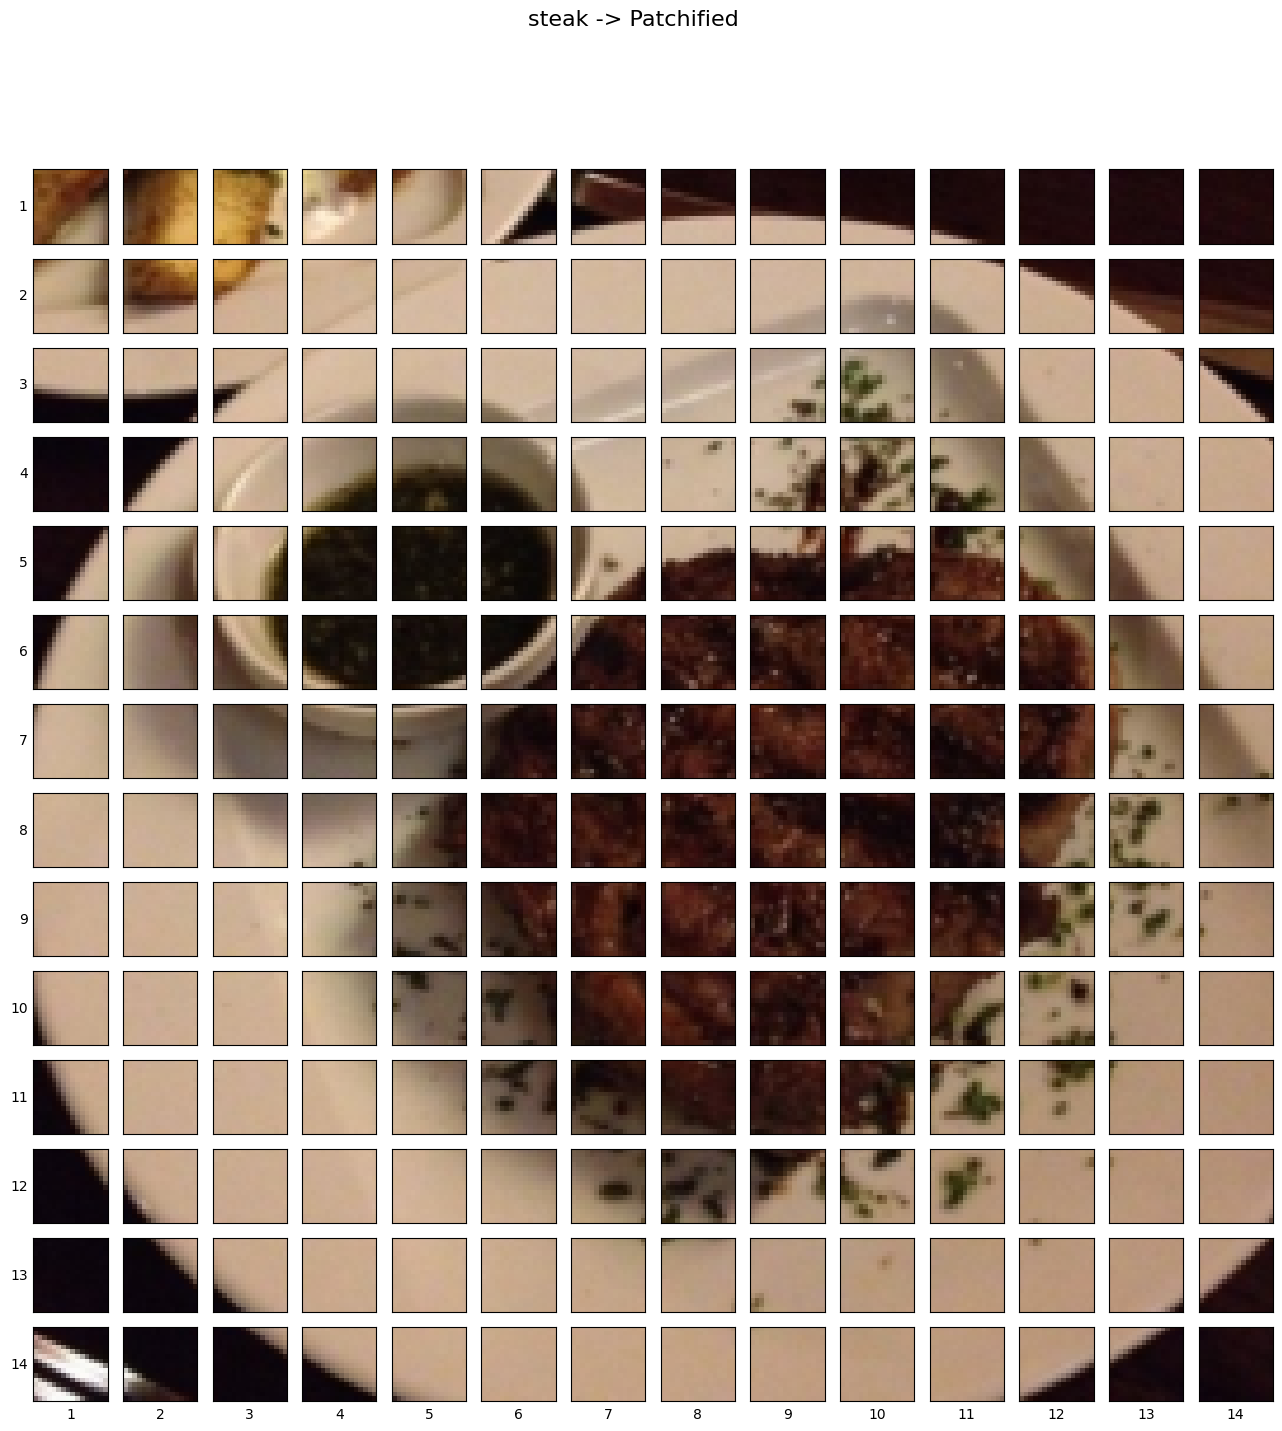

In [16]:
#img split
fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(img_permute[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i][j].set_xlabel(j+1)
        axs[i][j].set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [17]:
#img to patch
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)


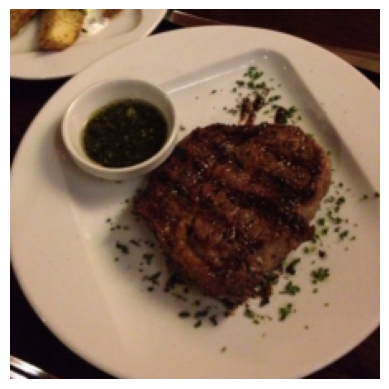

In [18]:
plt.imshow(img_permute)
plt.axis(False)
plt.show()

In [19]:
img_out_of_conv2d = conv2d(image.unsqueeze(0))
img_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

In [20]:
#flatten
img_out_of_conv2d.flatten(start_dim=2).shape

torch.Size([1, 768, 196])

In [21]:
nn.Flatten(start_dim=2)(img_out_of_conv2d).shape

torch.Size([1, 768, 196])

In [22]:
flatten_layer = nn.Flatten(start_dim=2)
flatten_layer(img_out_of_conv2d).shape

torch.Size([1, 768, 196])

In [23]:
img_out_of_conv2d_flatten = flatten_layer(img_out_of_conv2d)
img_out_of_conv2d_flatten.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [24]:
class IMG_TO_PATCH(nn.Module):
    def __init__(self, patch_size: int, in_channels: int=3, embed_dim: int=768):
        super().__init__()
        self.patch_size = patch

        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim,
                                kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2)

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        return x

In [25]:
patch_embedding = IMG_TO_PATCH(patch_size=patch_size)
patch_embedding(image).shape

torch.Size([1, 196, 768])

In [26]:
#class token embedding
batch_size = 1
embedding_dimension = 768
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [27]:
# Add the class token embedding to the front of the patch embedding
# add >> torch.cat
patch_embedding_img_with_class_token = torch.cat((class_token, patch_embedding(image)), dim=1)
patch_embedding_img_with_class_token.shape

torch.Size([1, 197, 768])

In [28]:
patch_embedding(image)

tensor([[[-0.3389, -0.2842,  0.0597,  ..., -0.1151, -0.1900,  0.3127],
         [-0.3786, -0.1512,  0.0410,  ..., -0.1221, -0.2885,  0.2839],
         [-0.4619, -0.4732,  0.1176,  ..., -0.2536, -0.2266,  0.4771],
         ...,
         [-0.2932, -0.5958,  0.2311,  ..., -0.1771, -0.0724,  0.5815],
         [-0.0629, -0.3275,  0.3616,  ..., -0.2487, -0.0124,  0.2277],
         [-0.0825, -0.0289,  0.0522,  ..., -0.0097, -0.0673,  0.0722]]],
       grad_fn=<PermuteBackward0>)

In [31]:
class_token

Parameter containing:
tensor([[[ 1.6827e-01, -1.0890e+00, -4.8535e-01,  6.4287e-01,  1.5877e-02,
          -1.4614e+00,  5.8751e-02,  1.3701e+00,  8.3757e-01,  6.8370e-01,
          -1.2055e-01,  9.1155e-02, -5.7983e-01,  6.1344e-01,  3.3717e-01,
          -1.2651e+00, -3.6919e-01,  1.1101e+00, -2.3960e+00,  2.8481e-01,
           2.2566e-02,  1.2419e+00,  8.5480e-01, -5.7660e-01, -3.4671e+00,
          -6.6586e-01,  4.8839e-01, -1.4830e+00,  6.8439e-01,  1.9181e-01,
           1.5680e+00, -2.2054e-01,  4.9354e-01, -4.1987e-01, -9.3708e-01,
          -8.9553e-01,  4.5076e-01,  1.2770e+00, -1.8973e-01, -1.9136e+00,
           8.9748e-01,  1.4504e+00, -2.8598e-01, -1.0829e+00,  2.0321e-01,
          -6.7094e-01, -1.8838e+00,  2.2150e-01, -2.9702e-01,  1.3575e+00,
           2.1975e-01, -1.2296e-01,  3.6512e-01,  4.0282e-01, -7.0811e-01,
          -9.1148e-01, -1.2206e-01,  8.4647e-01,  5.0347e-01,  3.8520e-01,
           1.3535e+00,  1.6227e+00,  1.1788e+00, -2.5633e-01, -4.8322e-01,
   

In [30]:
patch_embedding_img_with_class_token

tensor([[[ 0.1683, -1.0890, -0.4854,  ...,  0.7816, -0.2126, -0.7163],
         [-0.3389, -0.2842,  0.0597,  ..., -0.1151, -0.1900,  0.3127],
         [-0.3786, -0.1512,  0.0410,  ..., -0.1221, -0.2885,  0.2839],
         ...,
         [-0.2932, -0.5958,  0.2311,  ..., -0.1771, -0.0724,  0.5815],
         [-0.0629, -0.3275,  0.3616,  ..., -0.2487, -0.0124,  0.2277],
         [-0.0825, -0.0289,  0.0522,  ..., -0.0097, -0.0673,  0.0722]]],
       grad_fn=<CatBackward0>)

In [35]:
#create position embedding
num_patches = int(img_size/patch_size)**2

embedding_dim = patch_embedding_img_with_class_token.shape[-1]

position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim), requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [38]:
position_embedding

Parameter containing:
tensor([[[ 0.7018, -2.8559,  1.0391,  ...,  1.3735, -0.4345,  1.2274],
         [-0.0057, -0.1266,  1.3770,  ..., -0.8713, -0.8130,  1.1728],
         [-0.7833,  0.7742,  2.1152,  ..., -0.4906, -0.3826, -1.2939],
         ...,
         [ 0.6781,  2.1858,  1.3983,  ..., -0.3714,  1.1887, -0.8000],
         [ 0.6386, -0.4642, -0.8229,  ...,  0.3856,  0.2674,  0.5786],
         [ 0.0344,  0.5216,  0.5504,  ..., -0.2996, -1.0024, -2.6076]]],
       requires_grad=True)

In [36]:
patch_position_embedding = patch_embedding_img_with_class_token + position_embedding
patch_position_embedding, patch_position_embedding.shape

(tensor([[[ 0.8701, -3.9449,  0.5538,  ...,  2.1550, -0.6471,  0.5112],
          [-0.3446, -0.4108,  1.4366,  ..., -0.9864, -1.0030,  1.4855],
          [-1.1618,  0.6230,  2.1562,  ..., -0.6127, -0.6712, -1.0100],
          ...,
          [ 0.3850,  1.5900,  1.6294,  ..., -0.5484,  1.1163, -0.2185],
          [ 0.5758, -0.7916, -0.4614,  ...,  0.1369,  0.2550,  0.8063],
          [-0.0481,  0.4927,  0.6027,  ..., -0.3093, -1.0697, -2.5354]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [41]:
class IMG_TO_PATCH_WITH_EMBEDDINGS(nn.Module):
    def __init__(self, patch_size: int=16, img_size: int=224, in_channels: int=3, embed_dim: int=768):
        super().__init__()
        num_patches = int(img_size/patch_size)**2
        self.patch_size = patch_size
        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim,
                                kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2)
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embed_dim), requires_grad=True)

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = torch.cat((self.class_token, x), dim=1)
        x = x + self.position_embedding
        return x

In [49]:
img_patch_position_embedding=IMG_TO_PATCH_WITH_EMBEDDINGS()
img_patch_position_embedding(image).shape

torch.Size([1, 197, 768])

In [56]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embed_dim: int=768, num_heads: int=12):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim

        self.ln = nn.LayerNorm(embed_dim)
        self.msa = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, x):
        x = self.ln(x)
        #x = x.permute(1, 0, 2)
        x, _ = self.msa(query=x, key=x, value=x)
        return x

In [57]:
msa = MultiheadSelfAttentionBlock()
msa(patch_position_embedding).shape

torch.Size([1, 197, 768])

In [58]:
msa(img_patch_position_embedding(image)).shape

torch.Size([1, 197, 768])